In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Boats_Cleaned_dataset.csv')
df_cleaned = df.replace(0,np.nan).dropna(axis=0,how='any')
df_cleaned.head(3)

,Unnamed: 0,id,type,boatClass,make,model,year,condition,length_ft,beam_ft,...,minEngineYear,engineCategory,price,sellerId,city,state,zip,created_date,created_month,created_year
1,3,7228300,power,power-sportcruiser,Formula,400 Super Sport,2018,used,40.0,11.00,...,2018.0,inboard-outboard,539000.0,44260,Harsens Island,MI,48028,2019-09-24,9,2019
2,5,7271336,power,power-deck,Bayliner,Element 180,2020,new,18.0,7.42,...,2019.0,outboard-4s,26995.0,220570,Marietta,OH,45750,2019-11-02,11,2019
4,8,6824832,power,power-aft,Carver,440 Aft Cabin Motor Yacht,1994,used,44.0,15.00,...,1994.0,inboard,109900.0,17942,Middle River,MD,21220,2018-08-29,8,2018


In [3]:
(df_train, df_test) = train_test_split(df_cleaned,train_size=0.8,random_state=0)

X_train = df_train.drop(['Unnamed: 0', 'id', 'minEngineYear', 'maxEngineYear', 'price', 
             'sellerId', 'zip', 'city', 'created_date', 
                         'engineCategory', 'boatClass', 'model', 'make', 'hullMaterial', 'state'], axis=1)
y_train = df_train.price

X_test = df_test.drop(['Unnamed: 0', 'id', 'minEngineYear', 'maxEngineYear', 'price', 
             'sellerId', 'zip', 'city', 'created_date', 
                       'engineCategory', 'boatClass', 'model', 'make', 'hullMaterial', 'state'], axis=1)
y_test = df_test.price

print(X_train.shape)
X_train.head(3)

(774, 11)


,type,year,condition,length_ft,beam_ft,dryWeight_lb,fuelType,numEngines,totalHP,created_month,created_year
12613,power,2019,new,10.00,5.33,550.0,gasoline,1.0,60.0,8,2015
13252,power,2019,new,17.33,7.50,1450.0,gasoline,1.0,115.0,1,2019
13195,power,2019,new,41.00,11.92,16840.0,gasoline,4.0,1400.0,8,2018


In [4]:
X_train_num = X_train.select_dtypes(include='number')
X_train_cat = X_train.select_dtypes(exclude='number')

X_test_num = X_test.select_dtypes(include='number')
X_test_cat = X_test.select_dtypes(exclude='number')

stnd = StandardScaler().set_output(transform='pandas')
X_train_num = stnd.fit_transform(X_train_num)
X_test_num = stnd.transform(X_test_num)

X_train_cat = pd.get_dummies(X_train_cat,drop_first=False)
X_test_cat = pd.get_dummies(X_test_cat,drop_first=False)

X_train = pd.concat([X_train_num, X_train_cat],axis=1)
X_test = pd.concat([X_test_num, X_test_cat],axis=1)

X_train.head(3)

,year,length_ft,beam_ft,dryWeight_lb,numEngines,totalHP,created_month,created_year,type_power,type_sail,condition_new,condition_used,fuelType_diesel,fuelType_gasoline,fuelType_other
12613,0.765352,-1.799301,-1.275208,-0.636995,-0.687461,-0.931173,0.630228,-3.578514,True,False,True,False,False,True,False
13252,0.765352,-1.086281,-0.664662,-0.578726,-0.687461,-0.806202,-1.454372,0.730735,True,False,True,False,False,True,False
13195,0.765352,1.216199,0.578939,0.417671,3.168299,2.113564,0.630228,-0.346577,True,False,True,False,False,True,False



         best B = {'n_estimators': 100}
  validation R2 = 0.819


<Axes: xlabel='trees'>

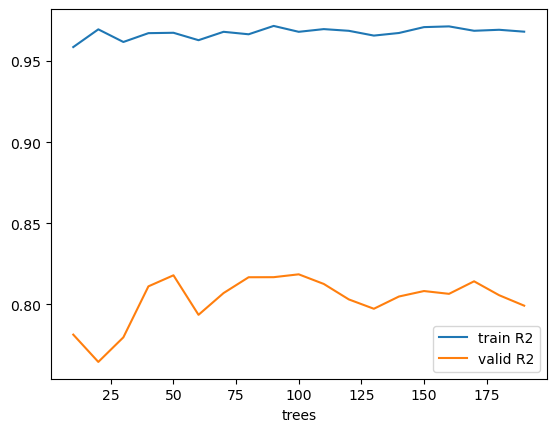

In [5]:
B = np.arange(10,200,10)
grid = {'n_estimators':B}

rf = RandomForestRegressor(max_features = 1/3)
rfCV = GridSearchCV(rf,param_grid=grid,return_train_score=True,n_jobs=-1)
rfCV.fit(X_train,y_train)

print()
print('         best B =',rfCV.best_params_)
print('  validation R2 =',rfCV.best_score_.round(3))

results = pd.DataFrame()
results['trees'] = grid['n_estimators']
results['train R2'] = rfCV.cv_results_['mean_train_score']
results['valid R2']  = rfCV.cv_results_['mean_test_score']
results.plot.line(x='trees',y=['train R2','valid R2'])

In [6]:
# oob score
rf = RandomForestRegressor(n_estimators=60,max_features = 1/3,oob_score=True)
rf.fit(X_train,y_train)
print('out-of-bag R2 =',rf.oob_score_.round(3))
print()
cv_results = cross_validate(rf,X_train,y_train,return_train_score=True)
R2_trainCV = cv_results['train_score'].mean()
R2_valid   = cv_results['test_score'].mean()
print('train R2 (CV) =',R2_trainCV.round(3),'  valid R2 =',R2_valid.round(3))
print()
R2_train = rf.score(X_train,y_train)
R2_test = rf.score(X_test, y_test)
print('     train R2 =',R2_train.round(3),
      '     test  R2 =', R2_test.round(3))

out-of-bag R2 = 0.773

train R2 (CV) = 0.969   valid R2 = 0.805

     train R2 = 0.969      test  R2 = 0.854


In [7]:
features_importance = pd.Series(rf.feature_importances_,index=X_train.columns)
features_importance.sort_values(ascending=False).round(5)

totalHP              0.23235
length_ft            0.22873
dryWeight_lb         0.15015
beam_ft              0.12241
year                 0.11373
numEngines           0.06198
created_month        0.01963
condition_used       0.01867
fuelType_gasoline    0.01377
condition_new        0.01216
fuelType_diesel      0.01202
created_year         0.01177
type_sail            0.00244
type_power           0.00020
fuelType_other       0.00000
dtype: float64